# Gender Bias Detection in the 14th and 15th legislatures

In [151]:
# load libraries 
import gensim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import copy

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA



### Some statistics

In [46]:
df_XIV = pd.read_csv("../data/legislature_XIV/df_questions.csv")
df_XV = pd.read_csv("../data/legislature_XV/df_questions.csv")

corpus_XIV = list(df_XIV['q_text'])
corpus_XV = list(df_XV['q_text'])

In [47]:
import mangoes
mangoes_XIV = mangoes.Corpus(corpus_XIV)
mangoes_XV = mangoes.Corpus(corpus_XV)

Counting words: 0it [00:00, ?it/s]

Counting words: 0it [00:00, ?it/s]

In [48]:
# number of sentences
print("CORPUS XIV")
print(mangoes_XIV.size, "sentences")

# number of words
print(len(mangoes_XIV.words_count), "words")

# frequencies of words
print(mangoes_XIV.words_count["homme"])

print("\nCORPUS XV")
print(mangoes_XV.size, "sentences")

# number of words
print(len(mangoes_XV.words_count), "words")

# frequencies of words
print(mangoes_XV.words_count["homme"])

CORPUS XIV
19734602 sentences
88885 words
1651

CORPUS XV
12702160 sentences
86135 words
1222


In [190]:
gender_def = [["femme", "homme"], ["femmes", "hommes"], ['mme', 'mr'],
              ["fille", "fils"], ["mère", "père"], ["mères", "pères"],["femelle", "mâle"], 
              ["sœur", "frère"], ["madame", "monsieur"], ["tante", "oncle"]]

l_count_XIV = np.empty(shape=(len(gender_def), 2))
l_perc_XIV = np.empty(shape=(len(gender_def), 2))

l_count_XV = np.empty(shape=(len(gender_def), 2))
l_perc_XV = np.empty(shape=(len(gender_def), 2))

for i, [female, male] in enumerate(gender_def):
  fem_XIV, mal_XIV = mangoes_XIV.words_count[female], mangoes_XIV.words_count[male]
  l_count_XIV[i] = fem_XIV, mal_XIV
  l_perc_XIV[i] = fem_XIV/(fem_XIV+mal_XIV), mal_XIV/(fem_XIV+mal_XIV)

  fem_XV, mal_XV = mangoes_XV.words_count[female], mangoes_XV.words_count[male]
  l_count_XV[i] = fem_XV, mal_XV
  l_perc_XV[i] = fem_XV/(fem_XV+mal_XV), mal_XV/(fem_XV+mal_XV)


# create dataframes
df_dict_XIV = {'tuple':np.array([[i,i] for i in range(len(gender_def))]).ravel(),
           'name' : np.array(gender_def).ravel(),
           'count' : l_count_XIV.ravel(),
           'percentage' : l_perc_XIV.ravel(),
           'gender': np.array([['F', 'M'] for i in range(len(gender_def))]).ravel()
}
df_dict_XV = {'tuple':np.array([[i,i] for i in range(len(gender_def))]).ravel(),
           'name' : np.array(gender_def).ravel(),
           'count' : l_count_XV.ravel(),
           'percentage' : l_perc_XV.ravel(),
           'gender': np.array([['F', 'M'] for i in range(len(gender_def))]).ravel()
}
df_XIV = pd.DataFrame(df_dict_XIV)
df_XV = pd.DataFrame(df_dict_XV)

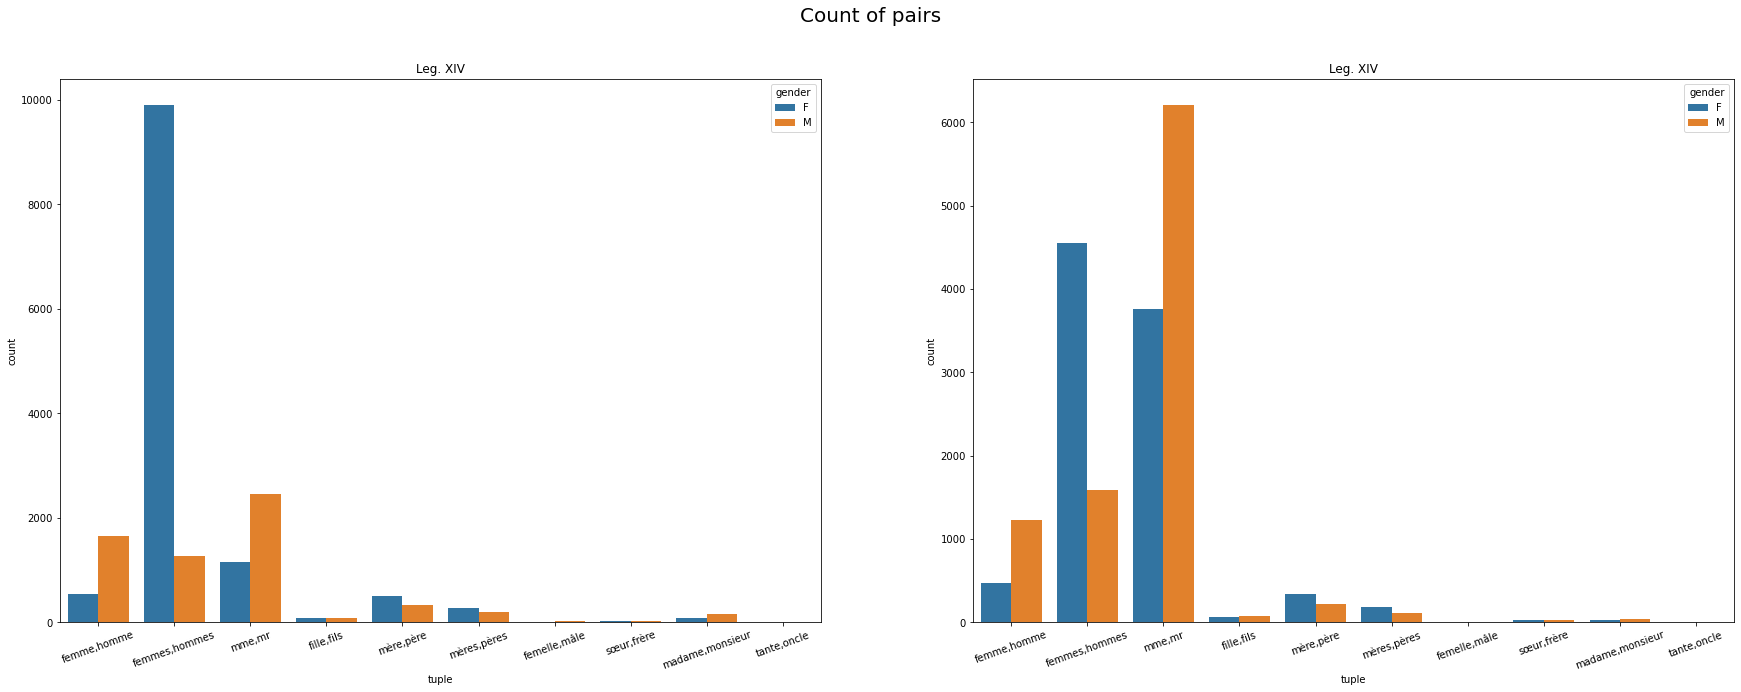

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
g_XIV = sns.barplot(data=df_XIV, y='count', x="tuple", hue="gender", ax=axes[0])
g_XIV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[0].set_title('Leg. XIV')

g_XV = sns.barplot(data=df_XV, y='count', x="tuple", hue="gender", ax=axes[1])
g_XV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[1].set_title('Leg. XIV')
plt.suptitle('Count of pairs', fontsize=20)
plt.show()


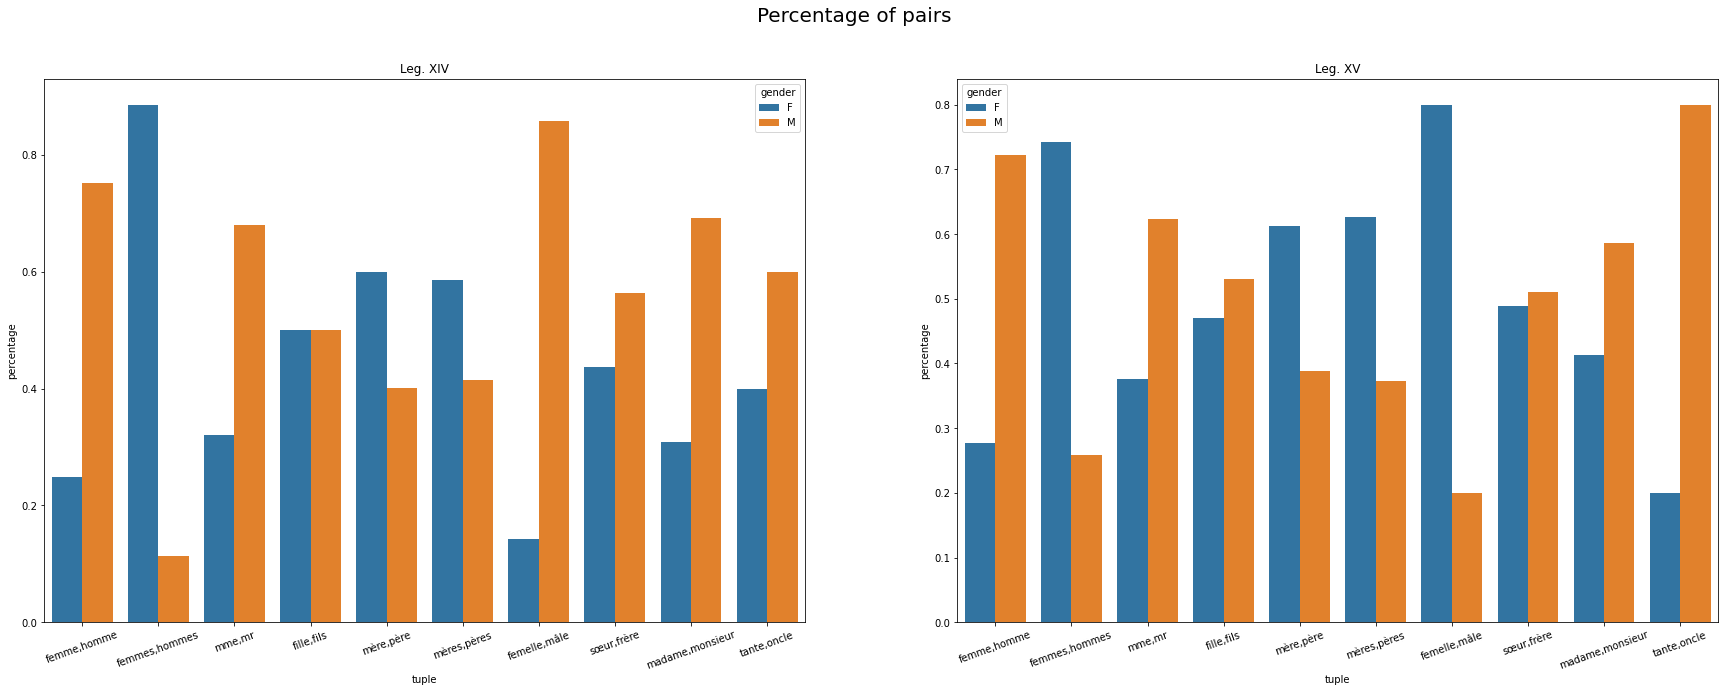

In [192]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
g_XIV = sns.barplot(data=df_XIV, y='percentage', x="tuple", hue="gender", ax=axes[0])
g_XIV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[0].set_title('Leg. XIV')

g_XV = sns.barplot(data=df_XV, y='percentage', x="tuple", hue="gender", ax=axes[1])
g_XV.set_xticklabels([f+','+m for (f,m) in gender_def], rotation=20)
axes[1].set_title('Leg. XV')
plt.suptitle('Percentage of pairs', fontsize=20)
plt.show()


In [197]:
df_XV[(df_XV['name']=='fille')]['percentage']

6    0.469697
Name: percentage, dtype: float64

It is important to consider only the pairs for which the percentage of women:men is $\approx$ 50:50.

In the sequel, we will consider the following pairs: 
* femme/homme and femmes/hommes (although the difference of percentages are high, we hope that the 2 pairs will cancel this together)
* mme/mr
* fille/fils
* mère/père and mères/pères
* sœur/frère
* madame/monsieur

In [159]:
#gender_list = [["femme", "homme"], ["femmes", "hommes"], ['mme', 'mr'], ['fille', 'fils'], ["mère", "père"], ["mères", "pères"], ['sœur', 'frère'], ['madame', 'monsieur']]
gender_list = [['fille', 'fils'], ["mère", "père"], ["mères", "pères"], ['sœur', 'frère'], ['madame', 'monsieur']]

### Loading Skip-Gram and CBOW models 


In [2]:
# load models of the 14th legislature 
model_w2v_sg_XIV = gensim.models.Word2Vec.load('../models/legislature_XIV/sg/w2v_sg_300D')
model_w2v_cbow_XIV = gensim.models.Word2Vec.load('../models/legislature_XIV/cbow/w2v_cbow_300D')

# load models of the 15th legislature 
model_w2v_sg_XV = gensim.models.Word2Vec.load('../models/legislature_XV/sg/w2v_sg_300D')
model_w2v_cbow_XV = gensim.models.Word2Vec.load('../models/legislature_XV/cbow/w2v_cbow_300D')

### Detection of semantic gender direction

In [222]:
def semantic_direction(model, leg, gender_list=None, scaling=False):
    """ Returns the n_comp principal components and their associated singular values """
    if gender_list == None:
        gender_list = [["femme", "homme"], ["femmes", "hommes"], ['mme', 'mr'], ['fille', 'fils'], ["mère", "père"], ["mères", "pères"], ['sœur', 'frère'], ['madame', 'monsieur']]

    # difference vectors of the 2 forms 
    if leg == 'XIV': df = df_XIV
    else: df = df_XV

    diff_gender_vect = []
    for female, male in gender_list:
        if scaling:
            vect_fem, vect_male = model.wv[female]*(1-df[df['name']==female]['percentage'].iloc[0]), model.wv[male]*(1-df[df['name']==male]['percentage'].iloc[0])
        else:
            vect_fem, vect_male = model.wv[female], model.wv[male]

        diff_gender_vect.append(vect_fem - vect_male)
        
    X = np.array(diff_gender_vect)

    pca = PCA(n_components=len(gender_list), random_state=42)
    pca.fit(X)
    return pca.components_ , pca.singular_values_

In [223]:
components_sg_XIV, sing_values_sg_XIV = semantic_direction(model_w2v_sg_XIV, leg='XIV', gender_list=gender_list, scaling=True)
components_cbow_XIV, sing_values_cbow_XIV = semantic_direction(model_w2v_cbow_XIV, leg='XIV', gender_list=gender_list, scaling=True)

components_sg_XV, sing_values_sg_XV = semantic_direction(model_w2v_sg_XV, leg='XV', gender_list=gender_list, scaling=True)
components_cbow_XV, sing_values_cbow_XV = semantic_direction(model_w2v_cbow_XV, leg='XV', gender_list=gender_list, scaling=True)

# the 1st principal component
principal_sg_XIV = components_sg_XIV[0]
principal_cbow_XIV = components_cbow_XIV[0]

principal_sg_XV = components_sg_XV[0]
principal_cbow_XV = components_cbow_XV[0]


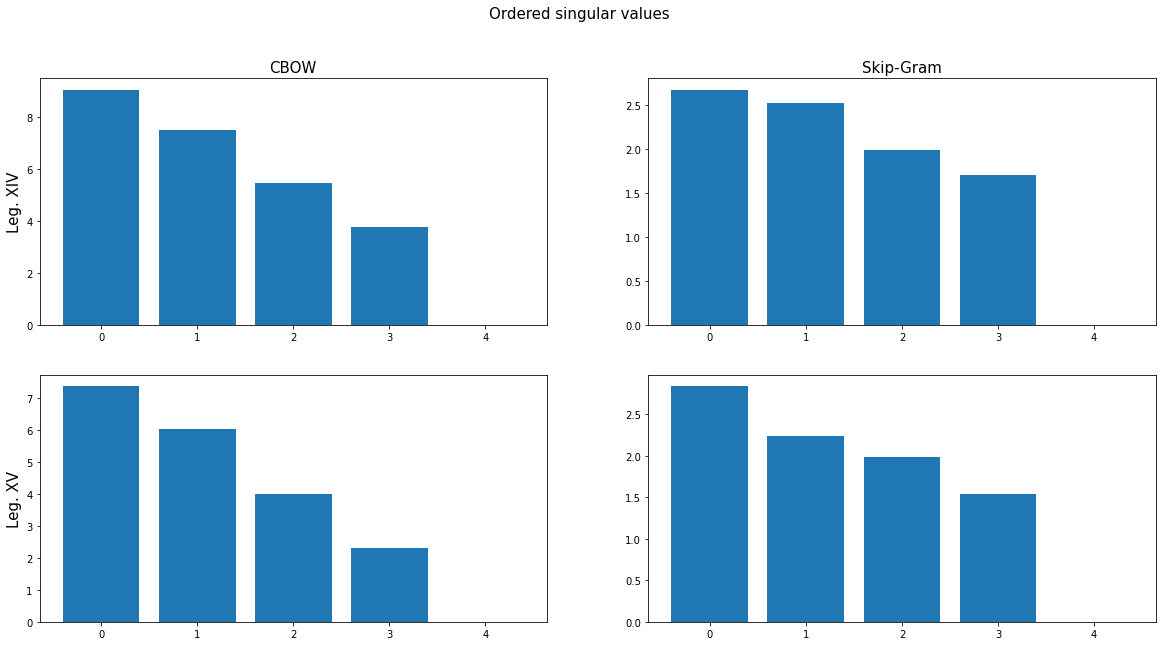

In [224]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

font_size=15

axes[0, 0].bar(x=np.arange(len(sing_values_cbow_XIV)), height=sing_values_cbow_XIV)
axes[0, 1].bar(x=np.arange(len(sing_values_sg_XIV)), height=sing_values_sg_XIV)
axes[1, 0].bar(x=np.arange(len(sing_values_cbow_XV)), height=sing_values_cbow_XV)
axes[1, 1].bar(x=np.arange(len(sing_values_sg_XV)), height=sing_values_sg_XV)
axes[0, 0].set_ylabel("Leg. XIV", fontsize=font_size)
axes[1, 0].set_ylabel("Leg. XV", fontsize=font_size)

axes[0, 0].set_title("CBOW", fontsize=font_size)
axes[0, 1].set_title("Skip-Gram", fontsize=font_size)
plt.suptitle('Ordered singular values',fontsize=font_size)

plt.show()

In [118]:
# gram schimdt algorithm 
def gram_schmidt(A):
    (n, m) = A.shape
    A_orth = np.empty((n, m))
    for i in range(m):
        q = A[:, i] # i-th column of A
        
        for j in range(i):
            q = q - np.dot(A_orth[:, j], A[:, i]) * A_orth[:, j]
        
        if np.array_equal(q, np.zeros(q.shape)):
            raise np.linalg.LinAlgError("The column vectors are not linearly independent")
        
        # normalize q
        q = q / np.sqrt(np.dot(q, q))
        
        # write the vector back in the matrix
        A_orth[:, i] = q
    return A_orth

#### Projection on the 1st principal component only 

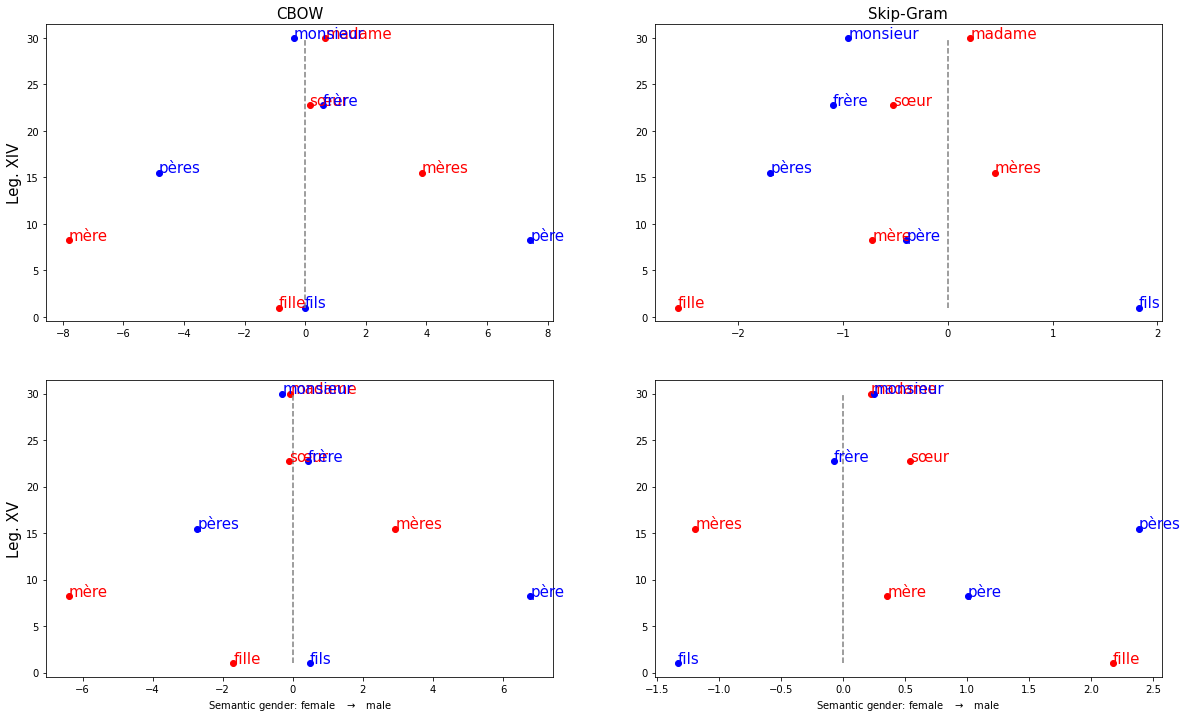

In [169]:
def plot_gender_pairs_1st_comp(model, principal_comp, ax=None, gender_list=None):
    if gender_list == None:
        gender_list = [['femme', 'homme'], ['femmes', 'hommes'], ['mme', 'mr'], ['fille', 'fils'], ['mère', 'père'], ['mères', 'pères'], ['sœur', 'frère'], ['madame', 'monsieur']]

    y_ = np.linspace(1, 30, len(gender_list))
    x_ = np.array([[principal_comp.dot(model.wv[female]), principal_comp.dot(model.wv[male])] for female, male in gender_list])

    if ax==None:
        plt.scatter(x_[:, 0], y_, color='red')  # female component
        plt.scatter(x_[:, 1], y_, color='blue') # male component
    else:
        ax.scatter(x_[:, 0], y_, color='red')  # female component
        ax.scatter(x_[:, 1], y_, color='blue') # male component

    for label, x, y in zip(np.array(gender_list)[:, 0], x_[:, 0], y_):
        if ax==None:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='red')
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='red')
        
    for label, x, y in zip(np.array(gender_list)[:, 1], x_[:, 1], y_):
        if ax==None:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='blue')
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='blue')
    if ax==None:
        plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

    else:
        ax.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')


fig, axes = plt.subplots(2, 2, figsize=(20, 12))

plot_gender_pairs_1st_comp(model_w2v_cbow_XIV, principal_cbow_XIV, ax=axes[0, 0], gender_list=gender_list)
plot_gender_pairs_1st_comp(model_w2v_sg_XIV, principal_sg_XIV, ax=axes[0, 1], gender_list=gender_list)
plot_gender_pairs_1st_comp(model_w2v_cbow_XV, principal_cbow_XV, ax=axes[1, 0], gender_list=gender_list)
plot_gender_pairs_1st_comp(model_w2v_sg_XV, principal_sg_XV, ax=axes[1, 1], gender_list=gender_list)

axes[0, 0].set_ylabel("Leg. XIV", fontsize=font_size)
axes[1, 0].set_ylabel("Leg. XV", fontsize=font_size)

axes[0, 0].set_title("CBOW", fontsize=font_size)
axes[0, 1].set_title("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.show()

#### Projection on the gender subspace

In [156]:
components_cbow_XIV.shape

(6, 300)

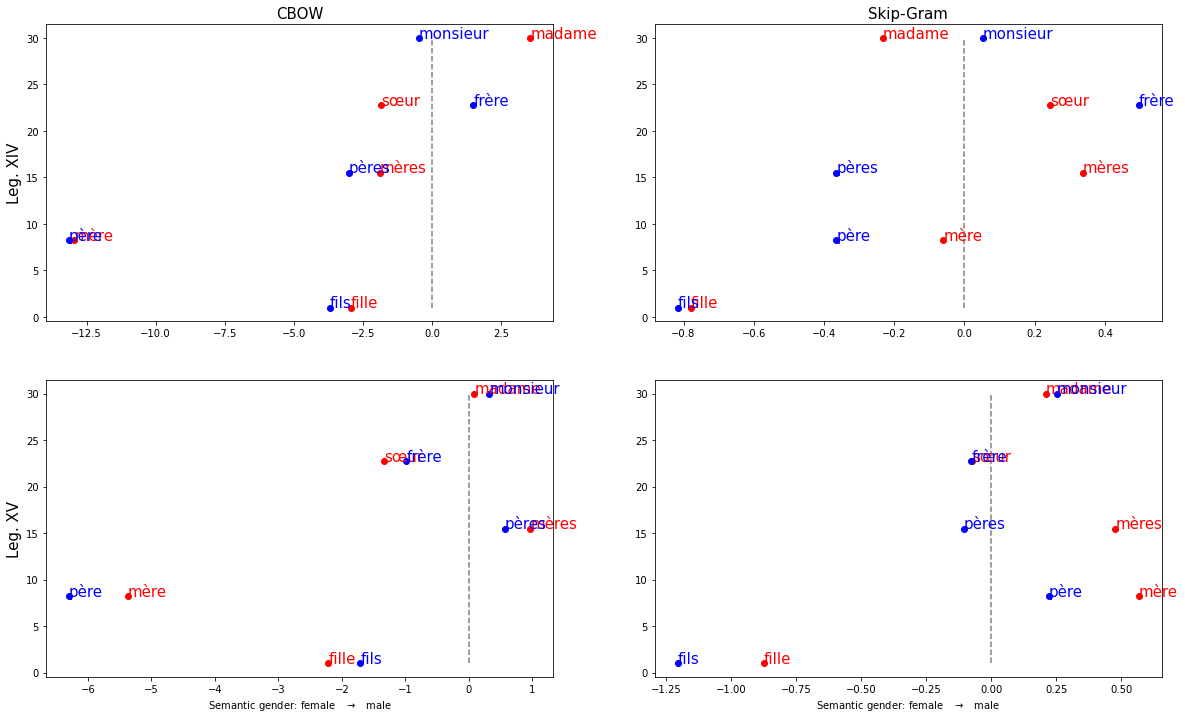

In [171]:
def plot_gender_pairs(model, components, ax=None, gender_list=None, n_comp=None):
    if gender_list == None:
        gender_list = [['femme', 'homme'], ['femmes', 'hommes'], ['mme', 'mr'], ['fille', 'fils'], ['mère', 'père'], ['mères', 'pères'], ['sœur', 'frère'], ['madame', 'monsieur']]

    components_orth = gram_schmidt(components_cbow_XIV.T)
    y_ = np.linspace(1, 30, len(gender_list))
    x_ = np.zeros((len(gender_list), 2))
    if n_comp == None: n_comp = components_orth.shape[1]
    for i, [female, male] in enumerate(gender_list):
        for j in range(n_comp):
            x_[i, 0] = copy.deepcopy(x_[i, 0]) + components_orth[:, j].dot(model.wv[female])  # female
            x_[i, 1] = copy.deepcopy(x_[i, 0]) + components_orth[:, j].dot(model.wv[male])  # female

    if ax==None:
        plt.scatter(x_[:, 0], y_, color='red')  # female component
        plt.scatter(x_[:, 1], y_, color='blue') # male component
    else:
        ax.scatter(x_[:, 0], y_, color='red')  # female component
        ax.scatter(x_[:, 1], y_, color='blue') # male component

    for label, x, y in zip(np.array(gender_list)[:, 0], x_[:, 0], y_):
        if ax==None:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='red')
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='red')
        
    for label, x, y in zip(np.array(gender_list)[:, 1], x_[:, 1], y_):
        if ax==None:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='blue')
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=15,
                            color='blue')
    if ax==None:
        plt.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

    else:
        ax.vlines(x=0, ymin=y_.min(), ymax=y_.max(), linestyles='dashed', colors='gray')

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

plot_gender_pairs(model_w2v_cbow_XIV, components_cbow_XIV, ax=axes[0, 0], gender_list=gender_list, n_comp=4)
plot_gender_pairs(model_w2v_sg_XIV, components_sg_XIV, ax=axes[0, 1], gender_list=gender_list, n_comp=4)
plot_gender_pairs(model_w2v_cbow_XV, components_cbow_XV, ax=axes[1, 0], gender_list=gender_list, n_comp=4)
plot_gender_pairs(model_w2v_sg_XV, components_sg_XV, ax=axes[1, 1], gender_list=gender_list, n_comp=4)

axes[0, 0].set_ylabel("Leg. XIV", fontsize=font_size)
axes[1, 0].set_ylabel("Leg. XV", fontsize=font_size)

axes[0, 0].set_title("CBOW", fontsize=font_size)
axes[0, 1].set_title("Skip-Gram", fontsize=font_size)
axes[1, 0].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)
axes[1, 1].set_xlabel(r"Semantic gender: female   $\rightarrow$   male", fontsize=10)

plt.show()

### Detection of semantic gender direction

In [ ]:
# semantic gender direction